## GAN using Keras

Xây dựng mô hình GAN để dự đoán phổ âm (spectrogram) của các âm của các từ số học: 0, 1, 2, ... 9

In [312]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical


In [313]:
def load_fsdd_by_digit(data_dir, sample_rate=16000, n_mels=64, max_files_per_digit=200):
    data = []
    labels = []
    for digit in range(10):
        files = [f for f in os.listdir(data_dir) if f.startswith(f"{digit}_") and f.endswith('.wav')][:max_files_per_digit]
        for file in files:
            path = os.path.join(data_dir, file)
            y, sr = librosa.load(path, sr=sample_rate)
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
            S_dB = librosa.power_to_db(S, ref=np.max)
            S_dB = librosa.util.fix_length(S_dB, size=64, axis=1)
            S_dB = S_dB[:64, :]
            S_dB = (S_dB + 80) / 80
            # normalize from dB range [-80, 0] to [-1, 1] to match generator tanh output
            S_dB = (S_dB + 80.0) / 40.0 - 1.0
            S_dB = np.expand_dims(S_dB, axis=-1)
            data.append(S_dB)
            labels.append(digit)
    return np.array(data), np.array(labels)

In [314]:
data, labels = load_fsdd_by_digit('recordings')
labels_onehot = to_categorical(labels, num_classes=10)

In [315]:
def build_conditional_generator(latent_dim, label_dim, output_shape):
    noise_input = layers.Input(shape=(latent_dim,))
    label_input = layers.Input(shape=(label_dim,))

    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(np.prod(output_shape), activation='tanh')(x)
    output = layers.Reshape(output_shape)(x)

    return models.Model([noise_input, label_input], output)

In [316]:
def build_conditional_discriminator(input_shape, label_dim):
    spectrogram_input = layers.Input(shape=input_shape)
    label_input = layers.Input(shape=(label_dim,))

    x = layers.Flatten()(spectrogram_input)
    x = layers.Concatenate()([x, label_input])

    x = layers.Dense(512)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dense(256)(x)
    x = layers.LeakyReLU(0.2)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    return models.Model([spectrogram_input, label_input], output)

In [324]:
latent_dim = 100
label_dim = 10
output_shape = (64, 64//3, 1)

generator = build_conditional_generator(latent_dim, label_dim, output_shape)
discriminator = build_conditional_discriminator(output_shape, label_dim)

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# CGAN model
noise_input = layers.Input(shape=(latent_dim,))
label_input = layers.Input(shape=(label_dim,))
generated_image = generator([noise_input, label_input])
discriminator.trainable = False
validity = discriminator([generated_image, label_input])
cgan = models.Model([noise_input, label_input], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')

In [325]:
def train_cgan(generator, discriminator, cgan, data, labels, latent_dim, epochs=1000, batch_size=32):
    half_batch = batch_size // 2
    for epoch in range(epochs):
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_samples = data[idx]
        real_labels = labels[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_labels = to_categorical(np.random.randint(0, 10, half_batch), num_classes=10)
        fake_samples = generator.predict([noise, fake_labels])

        d_loss_real = discriminator.train_on_batch([real_samples, real_labels], np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch([fake_samples, fake_labels], np.zeros((half_batch, 1)))

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        sampled_labels = to_categorical(np.random.randint(0, 10, batch_size), num_classes=10)
        g_loss = cgan.train_on_batch([noise, sampled_labels], np.ones((batch_size, 1)))

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | D loss: {d_loss_real[0] + d_loss_fake[0]:.4f} | G loss: {g_loss:.4f}")

In [326]:
latent_dim = 100
label_dim = 10
output_shape = data.shape[1:]

generator = build_conditional_generator(latent_dim, label_dim, output_shape)
discriminator = build_conditional_discriminator(output_shape, label_dim)
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# CGAN model
noise_input = layers.Input(shape=(latent_dim,))
label_input = layers.Input(shape=(label_dim,))
generated_image = generator([noise_input, label_input])
discriminator.trainable = False
validity = discriminator([generated_image, label_input])
cgan = models.Model([noise_input, label_input], validity)
cgan.compile(optimizer='adam', loss='binary_crossentropy')

In [327]:
train_cgan(generator, discriminator, cgan, data, labels_onehot, latent_dim=100, epochs=1000, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Epoch 0 | D loss: 2.9856 | G loss: 0.7445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━

In [328]:
def generate_digit_spectrogram(generator, digit, latent_dim=100):
    noise = np.random.normal(0, 1, (1, latent_dim))
    label = to_categorical([digit], num_classes=10)
    generated = generator.predict([noise, label])
    plt.imshow(generated[0].squeeze(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Predicted Spectrogram {digit}")
    plt.axis('on')
    plt.show()

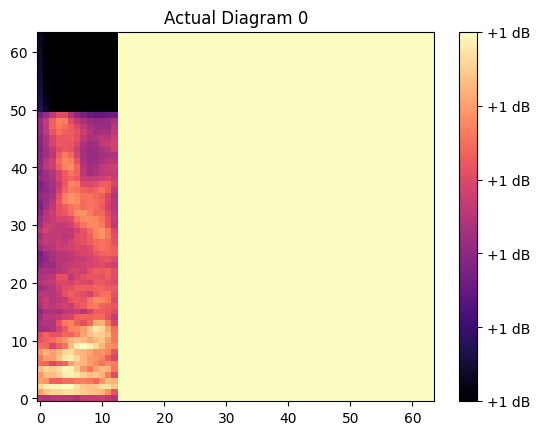

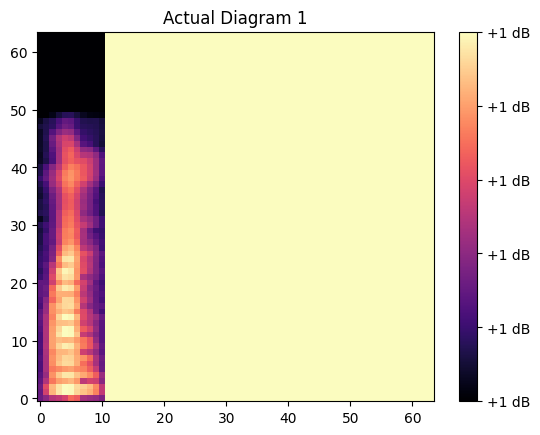

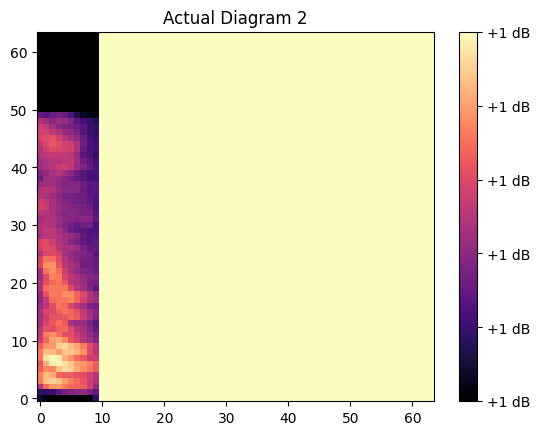

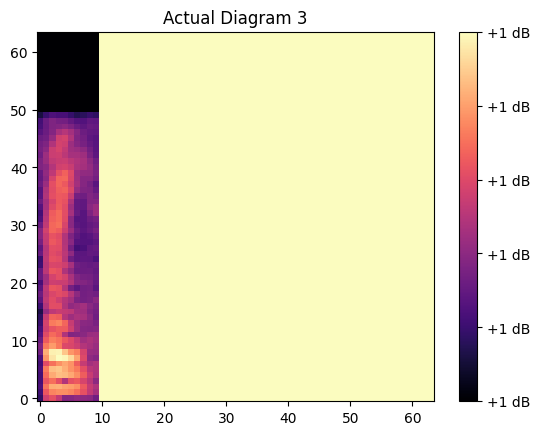

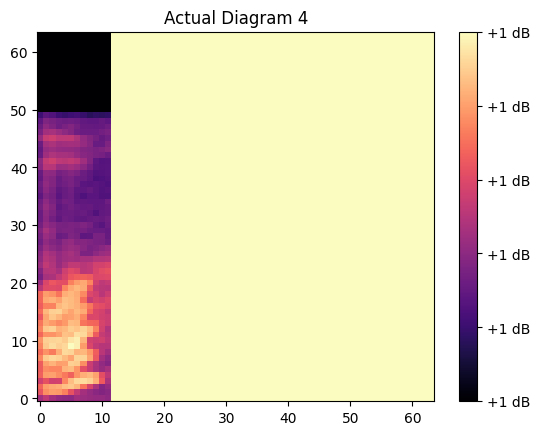

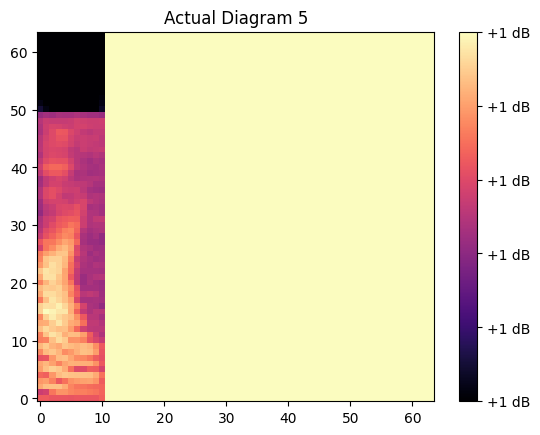

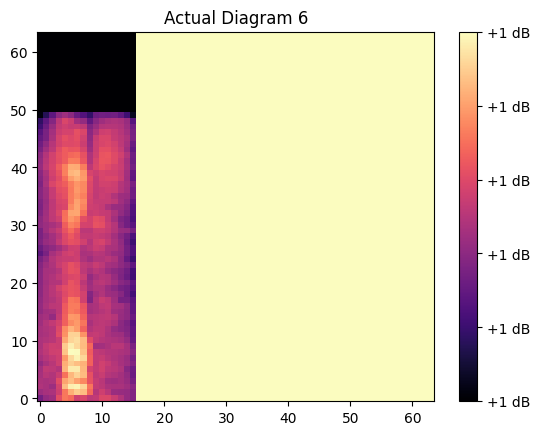

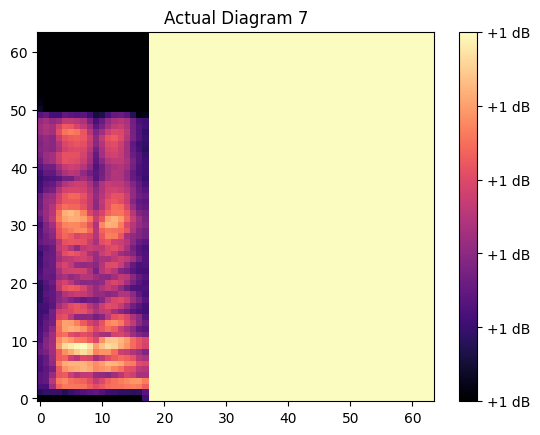

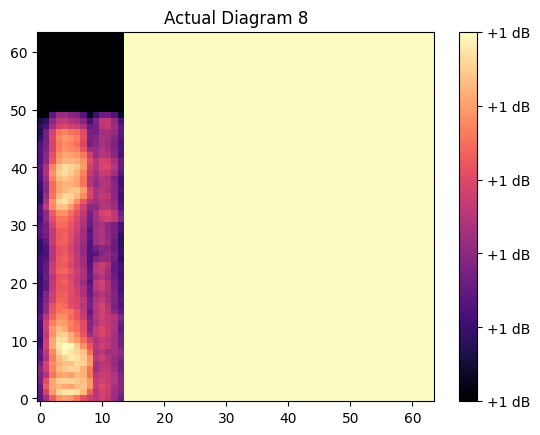

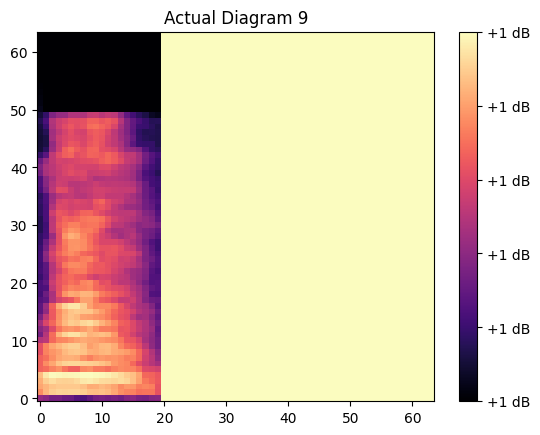

In [329]:
# This loop generates real and predicted spectrograms for digits 0-9
# For real spectrograms
for digit in range(10):
    idx = np.where(labels == digit)[0][0]
    # The diagram is truncated that it only shows part of the spectrogram
    # for better comparison with generated ones
    plt.imshow(data[idx].squeeze(), aspect='auto', origin='lower', cmap='magma')
    plt.title(f"Actual Diagram {labels[idx]}")
    plt.axis('on')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


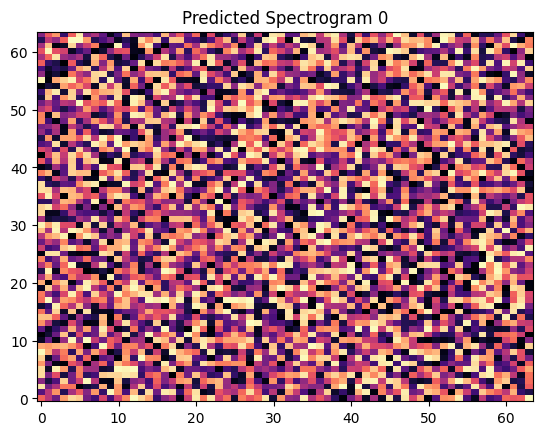

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


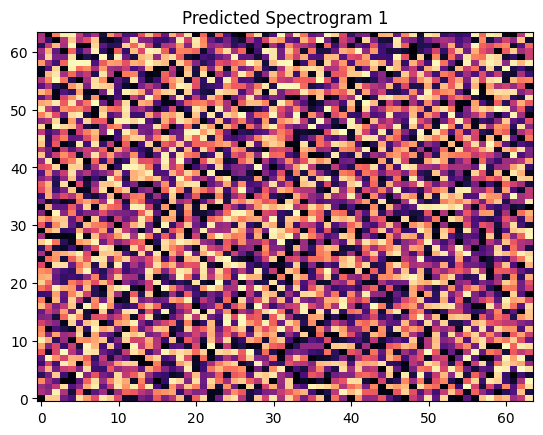

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


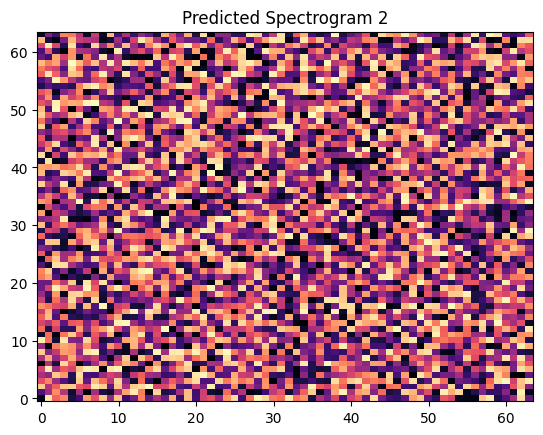

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


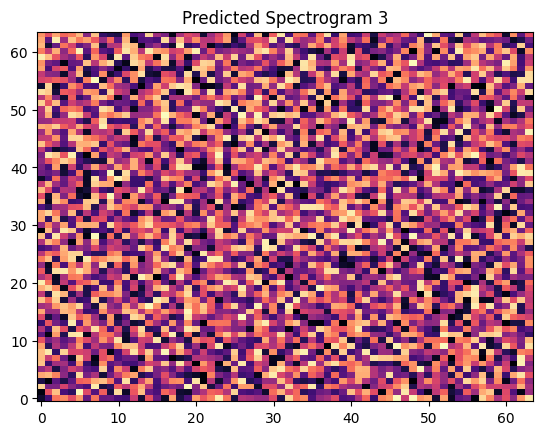

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


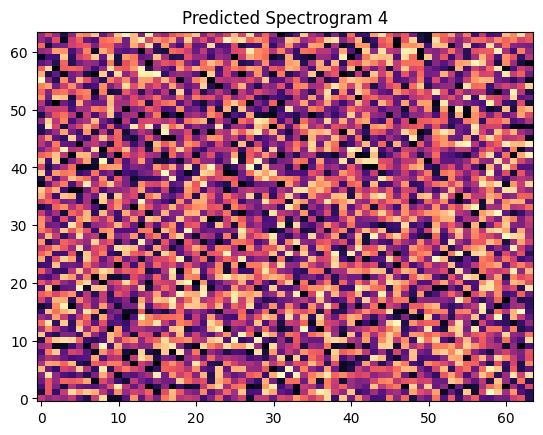

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


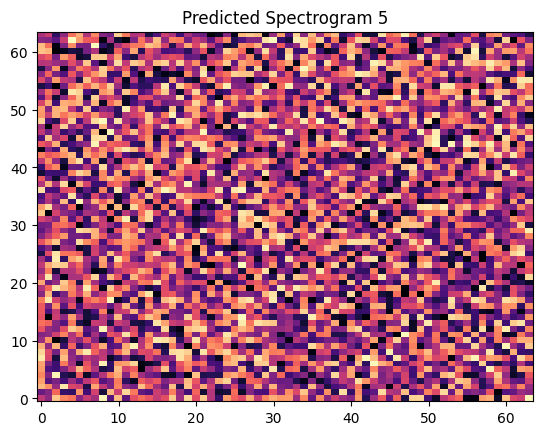

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


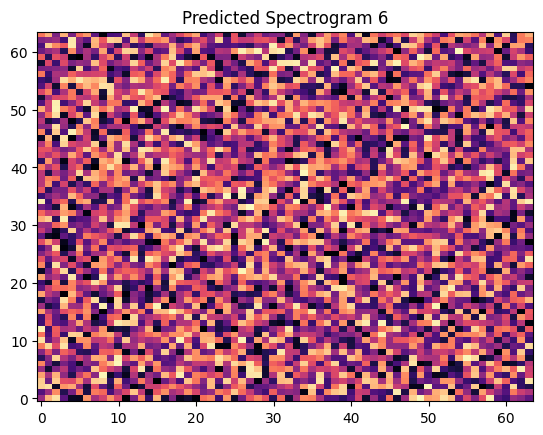

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


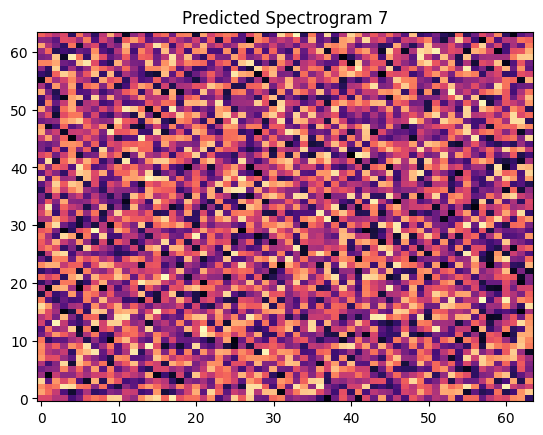

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


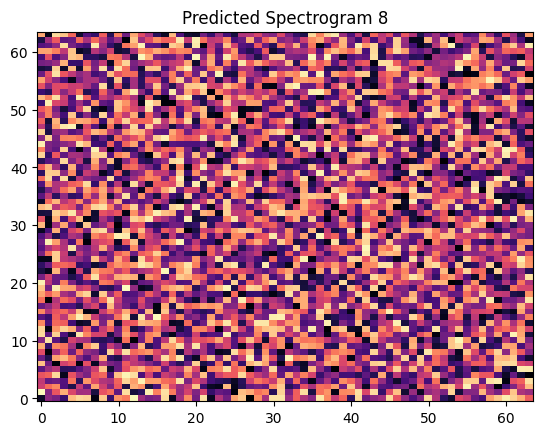

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


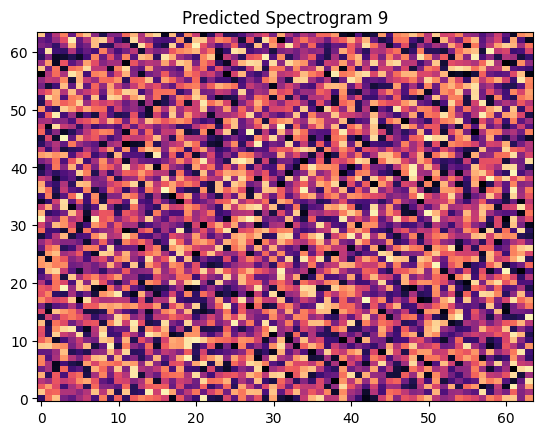

In [330]:
for digit in range(10):
    generate_digit_spectrogram(generator, digit=digit)